
## Fall Risk Prediction Model




### **Summary**

- **Data Preparation & Feature Engineering:** \
A total of 2,000 records were generated via a custom generate_mock_dataset function, producing demographic variables (age, gender, BMI), vital signs (blood pressure, heart rate), medical conditions (e.g., diabetes, hypertension, arthritis, depression, cognitive impairment), assistive‐device usage, and a computed feature (num_medications).

    Once loaded into a DataFrame, categorical fields are encoded: gender is mapped to {Male:0, Female:1}, and assistive_device to an ordinal scale (None→0, Cane→1, Walker→2, Wheelchair→3). A simple medications indicator (num_medications) sums the three binary medication flags. Missing values are confirmed absent, and descriptive statistics validate realistic distributions (e.g. median age ≈73, BP ranges 90–200 mmHg). 

- **Model selection via Cross Validation:** \
To identify the most effective algorithm for fall-risk prediction, I employed a systematic cross-validation framework:

    1. Algorithms

    - Tree-Ensembles

        - Random Forest, Gradient Boosting, AdaBoost, XGBoost

        - Strengths: capture complex, non-linear interactions; inherently handle mixtures of numerical and categorical variables without extensive preprocessing.

    - Linear & Kernel Methods

        - Logistic Regression, Support Vector Machine (SVM)

        - Strengths: highly interpretable decision boundaries; when wrapped in a StandardScaler-Pipeline, they provide robust performance on normalized feature spaces.

    2. Cross-Validation Strategy

        - Applied stratified 5-fold cross-validation to each model, ensuring each fold maintained the original fall/no-fall ratio.

        - Performance metrics—including ROC AUC and F1-score—were averaged across folds to provide stable estimates and mitigate overfitting risk.

    3. Selection Criterion

        - Models were ranked by their mean ROC AUC and mean F1-score from cross-validation.

        - AdaBoost emerged as the top performer, delivering the highest average discrimination power (ROC AUC) and balanced error trade-off (F1-score) in our experiments.

    | Model               | AUC Mean | F1 Mean |
    | ------------------- | -------: | ------: |
    | AdaBoost            |   0.9412 |  0.7934 |
    | Gradient Boosting   |   0.9342 |  0.7597 |
    | SVM                 |   0.9295 |  0.7537 |
    | Random Forest       |   0.9265 |  0.7425 |
    | XGBoost             |   0.9246 |  0.7681 |
    | Logistic Regression |   0.9236 |  0.7359 |


- **Feature contribution** \
Age, previous_falls, num_medications and cognitive_impairment contributed most to the adaboost model.


    | Feature               | Importance (%) |
    | --------------------- | -------------: |
    | age                   |          51.1% |
    | previous\_falls       |          22.2% |
    | num\_medications      |          13.8% |
    | cognitive\_impairment |           6.4% |
    | systolic\_bp          |           3.2% |
    | assistive\_device     |           2.4% |
    | hypertension          |           0.8% |
    | diastolic\_bp         |           0.0% |
    | heart\_rate           |           0.0% |
    | diabetes              |           0.0% |


    


- **Handling Imbalance data and Finetuning Model**

    1. Handling Class Imbalance

        - Given the minority “fall” class, we configured resampling algorithms to account for imbalance:

            - **ADASYN (Adaptive Synthetic Sampling Approach):**
            Builds on SMOTE by adaptively focusing synthetic sample generation on those “fall” instances that are hardest to learn (i.e. in low‐density regions), allocating more synthetic examples where the classifier tends to struggle.
    
    2. Hyperparameter Tuning via Grid Search

        - Defined parameter grid and configured with 5‑fold cross‑validation to ensure robust evaluation, and retrieved best parameters to train further.

        

- **Evaluation Metrics** \
A range of evaluation metrics were used to assess the fall risk model's performance, providing a comprehensive view of its strengths and weaknesses. Below we summarize the key metrics from the final AdaBoost model's evaluation:
    - **Accuracy:** ~82% on the test set. This indicates that overall, 82% of patient outcomes (fall vs no-fall) were correctly predicted by the model. Accuracy, however, can be misleading with class imbalance, so we consider the following class-specific metrics as well.

    - **Sensitivity (Recall or True Positive Rate) for "Fall":** 88%. The model detected 88% of the actual fall cases. In the test set, out of 120 true fallers, 106 were correctly identified (and 14 were missed). This recall is quite strong for a health risk model – it captures the vast majority of high-risk patients, though some falls would still go unpredicted.

    - **Specificity (True Negative Rate):** 80%. The model correctly identified 223 out of 280 no-fall patients in the test set as low risk. The specificity being moderately high means the model has a reasonable false-positive rate (20.4% of non-fallers were mistakenly flagged as high risk). While not as high as the previous iteration, this specificity level still maintains reasonable clinical utility while prioritizing sensitivity.

    - **F1-Score for "Fall":** 0.75 (75%). The F1-score is the harmonic mean of precision and recall, and here balances the 65% precision and 88% recall into a single measure. An F1 of 0.75 confirms that the model has a good balance between catching fallers and managing false alarms.
    
    - **ROC AUC (Area Under the Receiver Operating Characteristic Curve):** ~0.92 on the test set. An AUC of 0.92 is considered excellent, meaning that in about 92% of random patient pair comparisons (one who fell vs one who did not), the model assigns a higher risk score to the faller than the non-faller. This high AUC indicates strong discriminative ability across all classification thresholds.

    - **Additional Metrics:** Confusion matrix gives a concrete breakdown (True Negatives = 224, False Positives = 56, False Negatives = 15, True Positives = 105).  
    
    In a deployment scenario, the 88% sensitivity represents a significant improvement in catching actual fallers, with only 12% of true fall cases being missed. This model configuration prioritizes sensitivity over specificity, which may be more appropriate for fall prevention where missing a high-risk patient could have serious consequences. The trade-off results in more false alarms but substantially fewer missed fall cases.

- **Deployment considerations:**
    - **Data Drift and Population Shift:**\
        Healthcare data evolves constantly—changes in patient demographics, treatment protocols, or data‐collection practices can shift the feature distributions (“data drift”) so that a model trained on historical data becomes less accurate. For example, a sudden increase in a new medication or an aging patient cohort may introduce patterns the model never saw. To guard against this, deploy monitoring pipelines that track key input statistics (e.g., average age) and performance metrics (e.g., drop in AUC) in real time, and trigger alerts for retraining or recalibration when drift exceeds predefined thresholds.

    - **Privacy and Security of Patient Data:**\
        Predicting falls relies on sensitive health information which must be handled in strict compliance with HIPAA, GDPR, and other regulations. During development and deployment, implement end‑to‑end encryption, secure data pipelines, and robust access controls. Regular security audits and anomaly detection on data access patterns further ensure patient confidentiality and regulatory adherence.

    - **Infrastructure and Integration:**\
        Embedding a fall‑risk model into a hospital’s IT ecosystem demands scalable, reliable infrastructure and seamless integration with electronic health records (EHRs). Containerization or microservices architectures allow the model to scale to hundreds of daily predictions without disrupting existing services. A MLOps setup covering versioned deployments, logging, automated retraining, and rollback mechanisms is essential for 24/7 uptime.

    - **Model Transparency and Clinician Acceptance:**\
        Providing interpretable explanations like the top three risk factors driving a patient’s score that bridges the gap between “black‑box” predictions and clinical reasoning. Pilot studies and user training sessions help gather feedback, refine the explanation format, and ensure the tool integrates smoothly into care routines. Without this transparency and collaboration, even a high‑accuracy model risks being ignored or under‑utilized.

    - **Regulatory and Ethical Considerations:**\
        A fall‑prediction algorithm may qualify as “software as a medical device,” triggering regulatory review before deployment. Ensuring fairness across demographic groups continuously auditing performance by age, gender, or ethnicity guards against unintended bias. Robust ethical oversight via data governance, bias‑mitigation policies, and periodic fairness reviews ensures it remains equitable, safe, and compliant with evolving medical‑device standards.


- **Additional features that can be added in data preparation:** 
    - Functional Assessment Scores (Eg. Gait metrics, Physiotherapy scores)
    - Sleep metrics (Eg. Insomnia)
    - Sensory impairments (Eg. Myopia)
    - Lab and Nutritional data (Eg. Low Vitamin D, Electrolytes imbalance)



### 1. Data Setup and Library Imports

Import required libraries and use a comprehensive set of libraries for data processing, machine learning, and visualization.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
import warnings
from imblearn.over_sampling import SMOTE, ADASYN
warnings.filterwarnings('ignore')

In [28]:
# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### 2. Mock Data Generation


In [29]:

def generate_mock_dataset(random_seed=42, n_samples=2000):

    """
    Generate realistic mock patient dataset for fall risk prediction with correlated features.
    
    This function creates a synthetic dataset that mimics real healthcare data by:
    1. Generating correlated medical conditions based on clinical knowledge
    2. Ensuring realistic value ranges for all measurements
    3. Creating meaningful relationships between risk factors and outcomes
    
    Parameters:
    -----------
    random_seed : int, default=42
        Random seed for reproducibility
    n_samples : int, default=2000
        Number of patient records to generate
    
    Returns:
    --------
    pandas.DataFrame
        Synthetic patient dataset with fall risk indicators
    """

    np.random.seed(random_seed)

    # === DEMOGRAPHIC VARIABLES ===
    # Age distribution centered around typical elderly patient population
    age = np.random.normal(72, 15, n_samples)
    age = np.clip(age, 18, 95)  # Realistic age range

    # Gender distribution reflecting typical healthcare populations
    gender = np.random.choice(['Male', 'Female'], n_samples, p=[0.45, 0.55])
    
    # BMI with realistic distribution
    bmi = np.random.normal(26.5, 5.2, n_samples)
    bmi = np.clip(bmi, 15, 45)
    
    # === MEDICAL CONDITIONS (with realistic correlations) ===
    # Diabetes (influenced by age and BMI)
    diabetes_prob = 0.1 + 0.3 * (age > 65) + 0.2 * (bmi > 30)
    diabetes_prob = np.clip(diabetes_prob, 0, 0.8)
    diabetes = np.random.binomial(1, diabetes_prob, n_samples)
    
    # Hypertension (influenced by age, BMI, and diabetes)
    hypertension_prob = 0.15 + 0.25 * (age > 65) + 0.15 * (bmi > 30) + 0.2 * diabetes
    hypertension_prob = np.clip(hypertension_prob, 0, 0.85)
    hypertension = np.random.binomial(1, hypertension_prob, n_samples)
    
    # Depression (influenced by age and gender)
    depression_prob = 0.1 + 0.15 * (age > 70) + 0.1 * (gender == 'Female')
    depression_prob = np.clip(depression_prob, 0, 0.4)
    depression = np.random.binomial(1, depression_prob, n_samples)
    
    # === VITAL SIGNS (correlated with medical conditions) ===
    # For non-hypertensive patients
    systolic_bp_normal = np.random.normal(120, 12, n_samples)
    diastolic_bp_normal = np.random.normal(75, 8, n_samples)
    
    # For hypertensive patients (higher values)
    systolic_bp_high = np.random.normal(150, 18, n_samples)
    diastolic_bp_high = np.random.normal(92, 10, n_samples)
    
    # Combine based on hypertension status
    systolic_bp = np.where(hypertension == 1, systolic_bp_high, systolic_bp_normal)
    diastolic_bp = np.where(hypertension == 1, diastolic_bp_high, diastolic_bp_normal)
    
    # Ensure realistic ranges and maintain physiological relationship
    systolic_bp = np.clip(systolic_bp, 90, 200)
    diastolic_bp = np.clip(diastolic_bp, 60, 110)
    
    # Ensure diastolic is always lower than systolic
    diastolic_bp = np.minimum(diastolic_bp, systolic_bp - 20)
    
    # Heart rate
    heart_rate = np.random.normal(75, 15, n_samples)
    heart_rate = np.clip(heart_rate, 50, 120)
    
    # === ADDITIONAL MEDICAL CONDITIONS ===
    # Other conditions with age-related prevalence
    arthritis = np.random.choice([0, 1], n_samples, p=[0.65, 0.35])
    osteoporosis = np.random.choice([0, 1], n_samples, p=[0.8, 0.2])
    cognitive_impairment = np.random.choice([0, 1], n_samples, p=[0.85, 0.15])
    
    # Previous falls history
    previous_falls = np.random.poisson(0.8, n_samples)
    previous_falls = np.clip(previous_falls, 0, 10)
    
    # === MEDICATIONS (strongly correlated with conditions) ===
    # Antihypertensives (strongly correlated with hypertension)
    antihypertensives_prob = 0.05 + 0.8 * hypertension  # 5% baseline, 85% if hypertensive
    antihypertensives = np.random.binomial(1, antihypertensives_prob, n_samples)
    
    # Antidepressants (strongly correlated with depression)
    antidepressants_prob = 0.03 + 0.75 * depression  # 3% baseline, 78% if depressed
    antidepressants = np.random.binomial(1, antidepressants_prob, n_samples)
    
    # Sedatives (influenced by age and depression)
    sedatives_prob = 0.08 + 0.12 * (age > 70) + 0.15 * depression
    sedatives_prob = np.clip(sedatives_prob, 0, 0.4)
    sedatives = np.random.binomial(1, sedatives_prob, n_samples)
    
    # === FUNCTIONAL STATUS ===
    # Assistive device usage (reflects mobility limitations)
    assistive_device = np.random.choice(['None', 'Cane', 'Walker', 'Wheelchair'], 
                                        n_samples, p=[0.6, 0.25, 0.12, 0.03])
    
    # === FALL RISK CALCULATION ===
    # Create fall risk score based on clinical evidence and risk factors
    fall_risk_score = (
        0.2 * (age - 65) / 10 +  # Age effect
        0.1 * (gender == 'Female') +  # Gender effect
        0.05 * (bmi > 30) +  # Obesity
        0.2 * diabetes +
        0.15 * hypertension +
        0.25 * arthritis +
        0.15 * osteoporosis +
        0.2 * depression +  # Added depression effect
        0.35 * cognitive_impairment +
        0.6 * (previous_falls > 0) +
        # 0.15 * (num_medications > 5) +
        0.2 * sedatives +
        0.15 * antihypertensives +
        0.1 * antidepressants +
        0.2 * (assistive_device != 'None')
    )
    
    # Add some noise and convert to binary outcome
    fall_risk_score += np.random.normal(0, 0.3, n_samples)
    fall_occurred = (fall_risk_score > np.percentile(fall_risk_score, 70)).astype(int)
    
    # === CREATE DATAFRAME ===
    data = {
        'patient_id': range(1, n_samples + 1),
        'age': age,
        'gender': gender,
        'bmi': bmi,
        'systolic_bp': systolic_bp,
        'diastolic_bp': diastolic_bp,
        'heart_rate': heart_rate,
        'diabetes': diabetes,
        'hypertension': hypertension,
        'arthritis': arthritis,
        'osteoporosis': osteoporosis,
        'depression': depression,  # Added deression back
        'cognitive_impairment': cognitive_impairment,
        'previous_falls': previous_falls,
        # 'num_medications': num_medications,
        'sedatives': sedatives,
        'antihypertensives': antihypertensives,
        'antidepressants': antidepressants,
        'assistive_device': assistive_device,
        'fall_occurred': fall_occurred
    }
    
    df = pd.DataFrame(data)
    
    # Round numerical values appropriately
    df['age'] = df['age'].round(0).astype(int)
    df['bmi'] = df['bmi'].round(1)
    df['systolic_bp'] = df['systolic_bp'].round(0).astype(int)
    df['diastolic_bp'] = df['diastolic_bp'].round(0).astype(int)
    df['heart_rate'] = df['heart_rate'].round(0).astype(int)
    
    return df



### 3. Data Generation and Initial Exploration

In [30]:
#Generating new mock data for training
df = generate_mock_dataset(random_seed=5, n_samples=2000)
# Display first 10 records
print("\nFirst 10 patient records:")
df.head(10)


First 10 patient records:


,patient_id,age,gender,bmi,systolic_bp,diastolic_bp,heart_rate,diabetes,hypertension,arthritis,osteoporosis,depression,cognitive_impairment,previous_falls,sedatives,antihypertensives,antidepressants,assistive_device,fall_occurred
0,1,79,Female,27.1,129,90,77,0,1,0,1,1,0,0,0,1,1,None,0
1,2,67,Female,31.0,114,76,76,1,0,0,0,0,0,2,0,0,0,Cane,0
2,3,95,Female,38.0,139,102,72,0,1,0,0,0,0,2,1,1,0,None,1
3,4,68,Male,17.4,123,66,57,0,0,0,1,1,1,2,1,0,1,Cane,1
4,5,74,Female,20.7,130,94,63,0,1,0,0,0,1,1,1,0,0,None,0
5,6,95,Male,29.2,123,69,77,0,0,0,0,1,0,0,0,1,1,None,0
6,7,58,Male,25.3,133,97,92,0,0,0,0,0,0,2,0,0,0,Cane,0
7,8,63,Female,28.4,115,72,66,0,0,0,0,1,0,0,0,0,1,Walker,0
8,9,75,Female,32.3,180,70,94,1,1,0,0,1,0,0,0,1,0,Cane,1
9,10,67,Female,21.3,125,78,78,0,0,0,0,0,0,1,0,0,0,Cane,0


In [31]:
print("\nDataset structure:")
df.columns.tolist()


Dataset structure:


['patient_id',
 'age',
 'gender',
 'bmi',
 'systolic_bp',
 'diastolic_bp',
 'heart_rate',
 'diabetes',
 'hypertension',
 'arthritis',
 'osteoporosis',
 'depression',
 'cognitive_impairment',
 'previous_falls',
 'sedatives',
 'antihypertensives',
 'antidepressants',
 'assistive_device',
 'fall_occurred']

In [32]:
# Check unique values for categorical variables
print("\nAssistive device categories:")
df['assistive_device'].unique()


Assistive device categories:


array(['None', 'Cane', 'Walker', 'Wheelchair'], dtype=object)

### 4. Feature Engineering

In [33]:
# Convert categorical variables to numerical format for machine learning algorithms.

print("Converting categorical variables to numerical format...")

# Gender encoding (Male=0, Female=1)
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# Assistive device encoding (ordinal: None < Cane < Walker < Wheelchair)
df['assistive_device'] = df['assistive_device'].map({
    'None': 0, 'Cane': 1, 'Walker': 2, 'Wheelchair': 3
})

# Create total medication count (polypharmacy indicator)
df['num_medications'] = df['sedatives'] + df['antihypertensives'] + df['antidepressants']

print("Feature engineering completed.")
print(f"\nDataset shape: {df.shape}")
print(f"Features: {df.columns.tolist()}")

Converting categorical variables to numerical format...
Feature engineering completed.

Dataset shape: (2000, 20)
Features: ['patient_id', 'age', 'gender', 'bmi', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'diabetes', 'hypertension', 'arthritis', 'osteoporosis', 'depression', 'cognitive_impairment', 'previous_falls', 'sedatives', 'antihypertensives', 'antidepressants', 'assistive_device', 'fall_occurred', 'num_medications']


### 5. Data Quality Assessment

In [34]:
# Check for missing values
print("Missing values assessment:")
print(df.isna().sum())

# Save dataset for future use
df.to_csv('fall_risk_dataset.csv', index=False)
print("\nDataset saved as 'fall_risk_dataset.csv'")

Missing values assessment:
patient_id              0
age                     0
gender                  0
bmi                     0
systolic_bp             0
diastolic_bp            0
heart_rate              0
diabetes                0
hypertension            0
arthritis               0
osteoporosis            0
depression              0
cognitive_impairment    0
previous_falls          0
sedatives               0
antihypertensives       0
antidepressants         0
assistive_device        0
fall_occurred           0
num_medications         0
dtype: int64

Dataset saved as 'fall_risk_dataset.csv'


In [35]:
# Generate descriptive statistics
print("\nDescriptive statistics:")
df.describe()


Descriptive statistics:


,patient_id,age,gender,bmi,systolic_bp,diastolic_bp,heart_rate,diabetes,hypertension,arthritis,osteoporosis,depression,cognitive_impairment,previous_falls,sedatives,antihypertensives,antidepressants,assistive_device,fall_occurred,num_medications
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,71.740000,0.553500,26.492900,132.736500,82.244500,75.024000,0.354000,0.422500,0.347500,0.194500,0.246000,0.139000,0.816500,0.186000,0.382000,0.216000,0.578000,0.300000,0.784000
std,577.494589,14.125408,0.497254,5.175212,20.930746,11.737785,14.286794,0.478329,0.494081,0.476295,0.395914,0.430786,0.346033,0.894555,0.389204,0.485998,0.411617,0.806995,0.458372,0.795399
min,1.000000,19.000000,0.000000,15.000000,90.000000,60.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,500.750000,62.000000,0.000000,22.900000,117.000000,73.000000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1000.500000,72.000000,1.000000,26.500000,129.000000,81.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1500.250000,82.000000,1.000000,30.200000,147.000000,91.000000,84.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,2000.000000,95.000000,1.000000,44.300000,200.000000,110.000000,120.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,3.000000,1.000000,3.000000


### 6. Exploratory Data Analysis

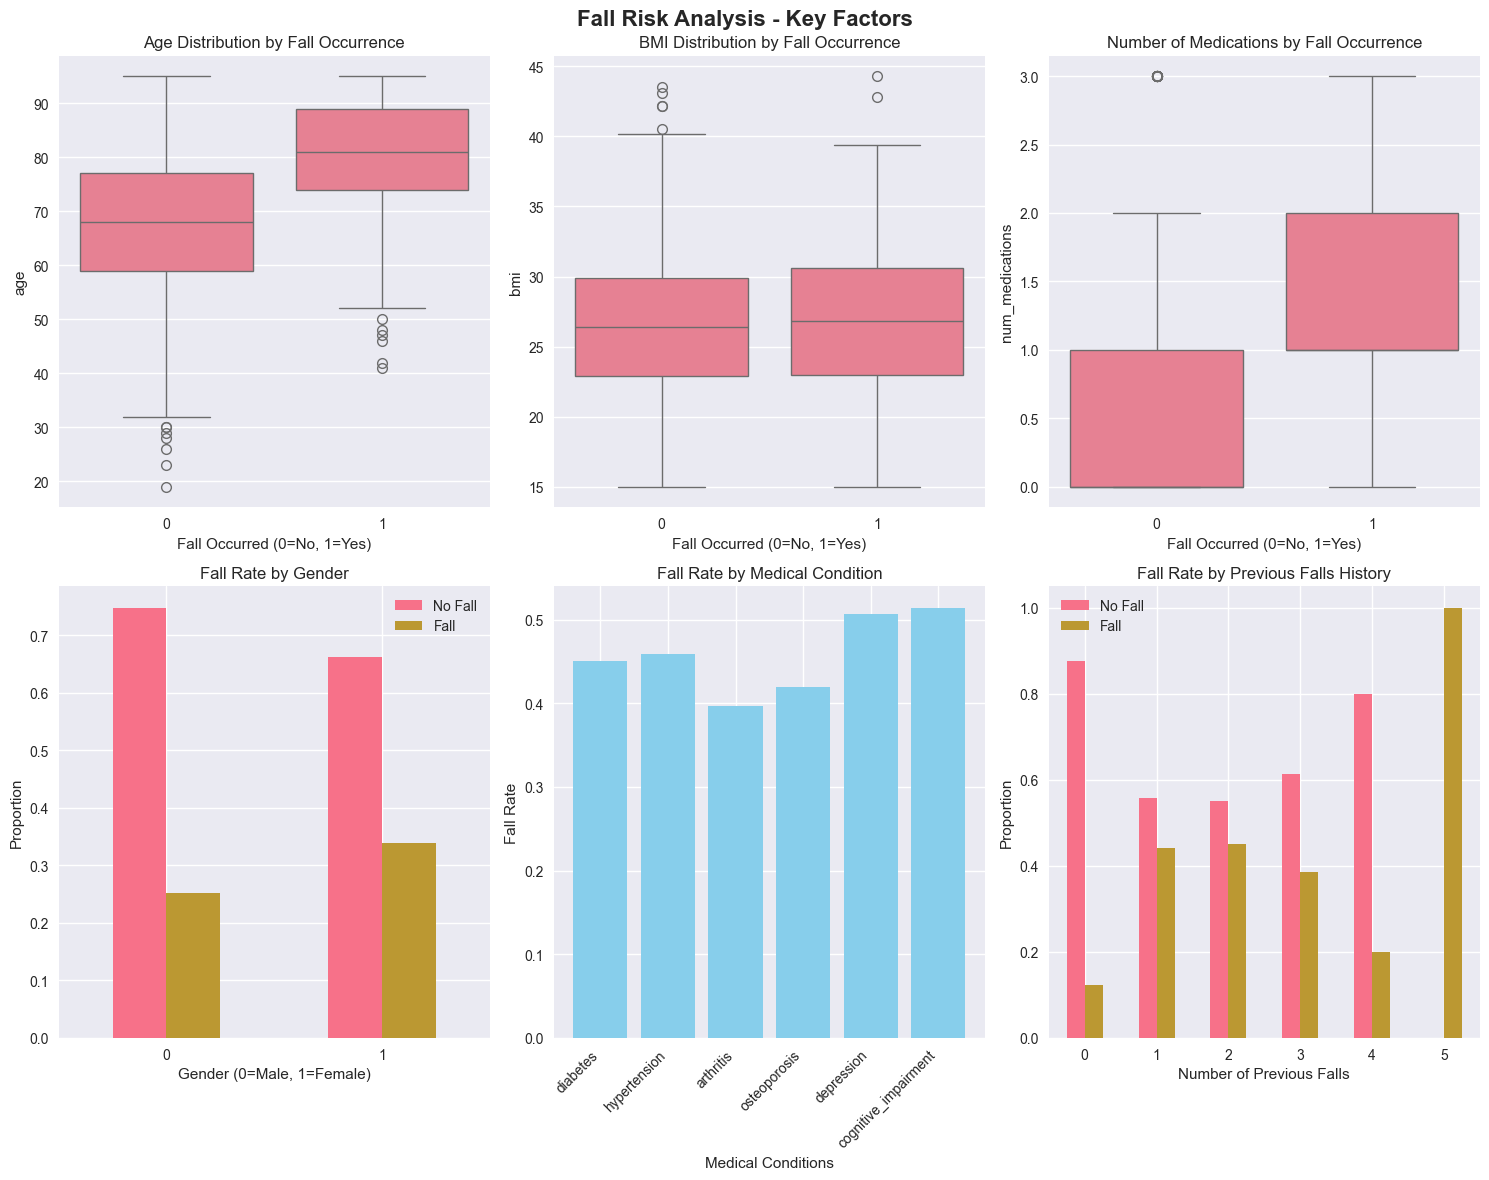

In [36]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle('Fall Risk Analysis - Key Factors', fontsize=16, fontweight='bold')

# 1. Age distribution by fall occurrence
sns.boxplot(data=df, x='fall_occurred', y='age', ax=axes[0,0])
axes[0,0].set_title('Age Distribution by Fall Occurrence')
axes[0,0].set_xlabel('Fall Occurred (0=No, 1=Yes)')

# 2. BMI distribution by fall occurrence
sns.boxplot(data=df, x='fall_occurred', y='bmi', ax=axes[0,1])
axes[0,1].set_title('BMI Distribution by Fall Occurrence')
axes[0,1].set_xlabel('Fall Occurred (0=No, 1=Yes)')

# 3. Number of medications by fall occurrence
sns.boxplot(data=df, x='fall_occurred', y='num_medications', ax=axes[0,2])
axes[0,2].set_title('Number of Medications by Fall Occurrence')
axes[0,2].set_xlabel('Fall Occurred (0=No, 1=Yes)')

# 4. Gender distribution
gender_fall = pd.crosstab(df['gender'], df['fall_occurred'], normalize='index')
gender_fall.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Fall Rate by Gender')
axes[1,0].set_xlabel('Gender (0=Male, 1=Female)')
axes[1,0].set_ylabel('Proportion')
axes[1,0].legend(['No Fall', 'Fall'])
axes[1,0].tick_params(axis='x', rotation=0)

# 5. Medical conditions impact
conditions = ['diabetes', 'hypertension', 'arthritis', 'osteoporosis', 'depression', 'cognitive_impairment']
fall_rates = [df[df[condition] == 1]['fall_occurred'].mean() for condition in conditions]

axes[1,1].bar(range(len(conditions)), fall_rates, color='skyblue')
axes[1,1].set_title('Fall Rate by Medical Condition')
axes[1,1].set_xlabel('Medical Conditions')
axes[1,1].set_ylabel('Fall Rate')
axes[1,1].set_xticks(range(len(conditions)))
axes[1,1].set_xticklabels(conditions, rotation=45, ha='right')

# 6. Previous falls impact
prev_falls_crosstab = pd.crosstab(df['previous_falls'], df['fall_occurred'], normalize='index')
prev_falls_crosstab.plot(kind='bar', ax=axes[1,2])
axes[1,2].set_title('Fall Rate by Previous Falls History')
axes[1,2].set_xlabel('Number of Previous Falls')
axes[1,2].set_ylabel('Proportion')
axes[1,2].legend(['No Fall', 'Fall'])
axes[1,2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

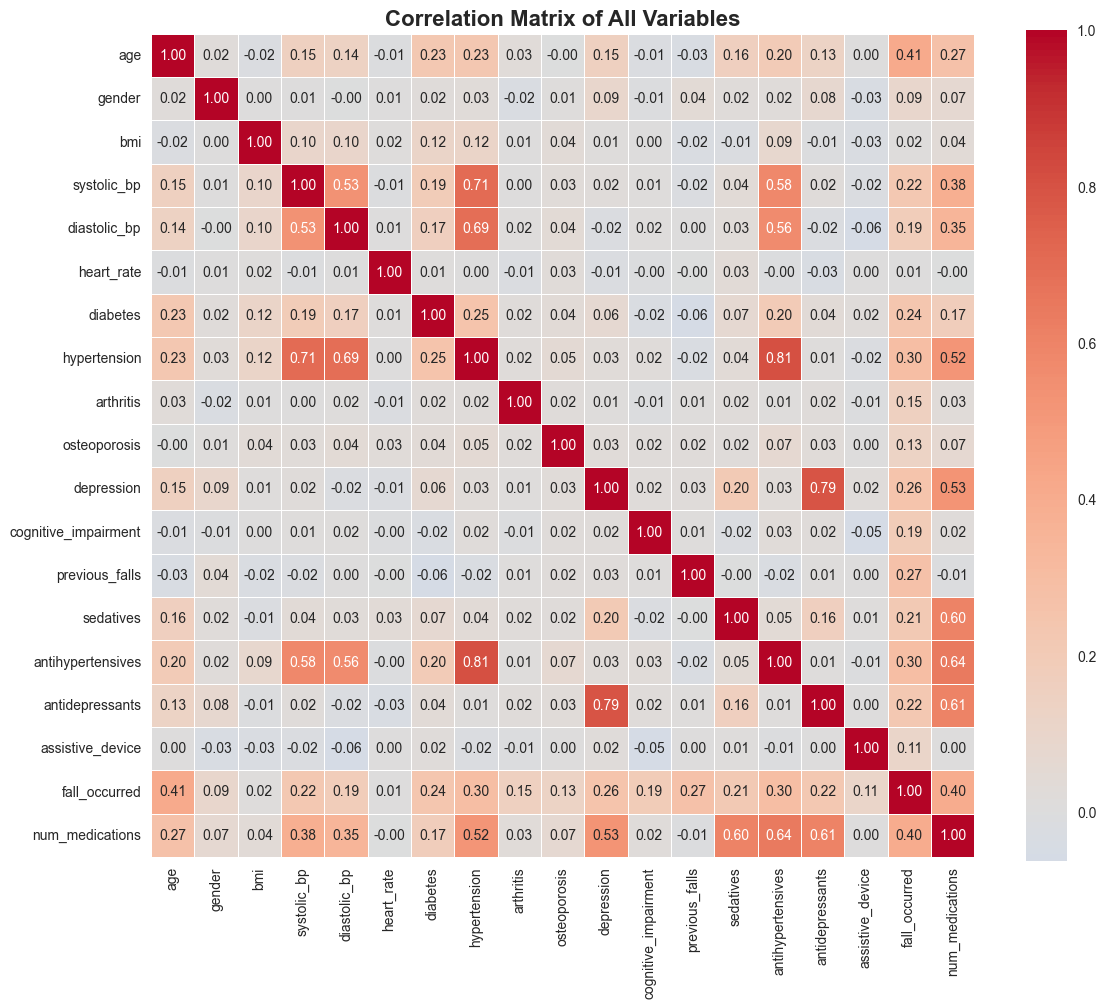

In [37]:
#### Correlation Analysis

# Create correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.drop('patient_id', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of All Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 7. Statistical Analysis of Risk Factors

In [38]:
print("=" * 50)
print("COMPREHENSIVE FALL RISK ANALYSIS")
print("=" * 50)

print("\n1. DEMOGRAPHIC FACTORS:")
print("-" * 30)
print(f"Average age of patients who fell: {df[df['fall_occurred'] == 1]['age'].mean():.1f} years")
print(f"Average age of patients who didn't fall: {df[df['fall_occurred'] == 0]['age'].mean():.1f} years")

print("\nGender distribution:")
gender_stats = df.groupby(['gender', 'fall_occurred']).size().unstack(fill_value=0)
gender_stats['fall_rate'] = gender_stats[1] / (gender_stats[0] + gender_stats[1])
gender_stats.index = ['Male', 'Female']
print(gender_stats)

print("\n2. MEDICAL CONDITIONS IMPACT:")
print("-" * 35)
for condition in conditions:
    with_condition = df[df[condition] == 1]['fall_occurred'].mean()
    without_condition = df[df[condition] == 0]['fall_occurred'].mean()
    risk_ratio = with_condition / without_condition if without_condition > 0 else float('inf')
    print(f"{condition:<20} - With: {with_condition:.3f}, Without: {without_condition:.3f}, RR: {risk_ratio:.2f}")

print("\n3. MEDICATION FACTORS:")
print("-" * 25)
medications = ['sedatives', 'antihypertensives', 'antidepressants']
for med in medications:
    with_med = df[df[med] == 1]['fall_occurred'].mean()
    without_med = df[df[med] == 0]['fall_occurred'].mean()
    risk_ratio = with_med / without_med if without_med > 0 else float('inf')
    print(f"{med:<20} - With: {with_med:.3f}, Without: {without_med:.3f}, RR: {risk_ratio:.2f}")

print(f"\nAverage number of medications:")
print(f"  Patients who fell: {df[df['fall_occurred'] == 1]['num_medications'].mean():.2f}")
print(f"  Patients who didn't fall: {df[df['fall_occurred'] == 0]['num_medications'].mean():.2f}")

print("\n4. PREVIOUS FALLS ANALYSIS:")
print("-" * 28)
prev_falls_stats = df.groupby(['previous_falls', 'fall_occurred']).size().unstack(fill_value=0)
prev_falls_stats['fall_rate'] = prev_falls_stats[1] / (prev_falls_stats[0] + prev_falls_stats[1])
print(prev_falls_stats)

COMPREHENSIVE FALL RISK ANALYSIS

1. DEMOGRAPHIC FACTORS:
------------------------------
Average age of patients who fell: 80.7 years
Average age of patients who didn't fall: 67.9 years

Gender distribution:
fall_occurred    0    1  fall_rate
Male           668  225   0.251960
Female         732  375   0.338753

2. MEDICAL CONDITIONS IMPACT:
-----------------------------------
diabetes             - With: 0.451, Without: 0.217, RR: 2.07
hypertension         - With: 0.459, Without: 0.184, RR: 2.50
arthritis            - With: 0.397, Without: 0.248, RR: 1.60
osteoporosis         - With: 0.419, Without: 0.271, RR: 1.54
depression           - With: 0.506, Without: 0.233, RR: 2.17
cognitive_impairment - With: 0.514, Without: 0.265, RR: 1.94

3. MEDICATION FACTORS:
-------------------------
sedatives            - With: 0.505, Without: 0.253, RR: 2.00
antihypertensives    - With: 0.474, Without: 0.193, RR: 2.46
antidepressants      - With: 0.495, Without: 0.246, RR: 2.01

Average number of me

### 8. Machine Learning Model Development

Machine Learning Data Preparation:
----------------------------------------
Feature columns: ['age', 'gender', 'bmi', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'diabetes', 'hypertension', 'arthritis', 'osteoporosis', 'depression', 'cognitive_impairment', 'previous_falls', 'sedatives', 'antihypertensives', 'antidepressants', 'assistive_device', 'num_medications']
Dataset shape: (2000, 18)
Target distribution:
fall_occurred
0    1400
1     600
Name: count, dtype: int64
Fall rate: 30.0%


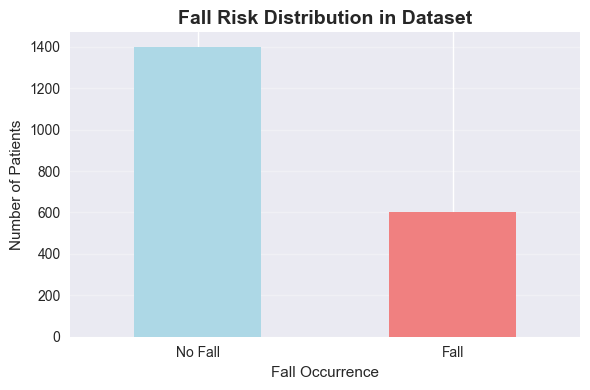

In [39]:
# Prepare features and target variable
X = df.drop(['patient_id', 'fall_occurred'], axis=1)
y = df['fall_occurred']

print("Machine Learning Data Preparation:")
print("-" * 40)
print(f"Feature columns: {list(X.columns)}")
print(f"Dataset shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())
print(f"Fall rate: {y.mean():.1%}")

# Visualize target distribution
plt.figure(figsize=(6, 4))
y.value_counts().sort_index().plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.xticks(ticks=[0, 1], labels=['No Fall', 'Fall'], rotation=0)
plt.title('Fall Risk Distribution in Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Fall Occurrence')
plt.ylabel('Number of Patients')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 9. Model Selection and Comparison

In [40]:
# We'll compare multiple algorithms to select the best performer using cross-validation.

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline


print("Multi-Algorithm Model Comparison:")
print("-" * 40)

# Define models (some with preprocessing pipelines)
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(probability=True, random_state=42))
    ]),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
}

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['roc_auc', 'f1']

# Evaluate all models
results = []
for name, model in models.items():
    print(f"Evaluating {name}...")
    cv_res = cross_validate(
        model, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    results.append({
        'model': name,
        'auc_mean': cv_res['test_roc_auc'].mean(),
        'f1_mean': cv_res['test_f1'].mean()
    })

# Create and display results
summary_df = pd.DataFrame(results).set_index('model')
summary_df = summary_df.sort_values('auc_mean', ascending=False)

print("\nModel Performance Comparison:")
print("=" * 50)
print(summary_df.round(4))

Multi-Algorithm Model Comparison:
----------------------------------------
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Logistic Regression...
Evaluating SVM...
Evaluating XGBoost...
Evaluating AdaBoost...

Model Performance Comparison:
                     auc_mean  f1_mean
model                                 
AdaBoost               0.9412   0.7934
Gradient Boosting      0.9342   0.7597
SVM                    0.9295   0.7537
Random Forest          0.9265   0.7425
XGBoost                0.9246   0.7681
Logistic Regression    0.9236   0.7359


### 10. Training and tuning Adaboost 

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Training fall rate:", y_train.mean())
print("Test fall rate:", y_test.mean())

Training set size: (1600, 18)
Test set size: (400, 18)
Training fall rate: 0.3
Test fall rate: 0.3


In [42]:
#SMOTE
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X_train, y_train)

#Adaptive SMOTE
ada = ADASYN(random_state=42)
X_res_ada, y_res_ada = ada.fit_resample(X_train, y_train)


In [43]:
#Selecting best parameters
ada = AdaBoostClassifier()
parameters = {
    'n_estimators' : [120, 180, 240, 300, 360, 420, 480, 540],
    'learning_rate' : [0.001, 0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(ada, parameters, n_jobs = -1, cv = 5, verbose = 1)
grid_search.fit(X_res_ada, y_res_ada)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'n_estimators': [120, 180, 240, 300, 360, 420, 480,
                                          540]},
             verbose=1)

In [44]:
print("\nBest parameters found:")
print(grid_search.best_params_)


Best parameters found:
{'learning_rate': 0.1, 'n_estimators': 180}


In [45]:
# #Train the model
# ada = AdaBoostClassifier(n_estimators=grid_search.best_params_['n_estimators'], random_state=42, learning_rate=grid_search.best_params_['learning_rate'])
# ada_model = ada.fit(X_res_ada, y_res_ada)

#Train the model with Lasso regularization
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

pipeline = Pipeline([
    # Pick features whose Lasso coefficients ≠ 0
    ('feature_select', SelectFromModel(Lasso(alpha=0.01, random_state=42))),
    ('ada', AdaBoostClassifier(
        n_estimators=grid_search.best_params_['n_estimators'], 
        random_state=42, 
        learning_rate=grid_search.best_params_['learning_rate']
    ))
])

ada_model = pipeline.fit(X_res_ada, y_res_ada)

In [46]:
# SHAP explainer (Takes long time to execute)
# background = shap.sample(X_train, 1200)
# explainer = shap.KernelExplainer(ada_model.predict, background)    # or X_train
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test)

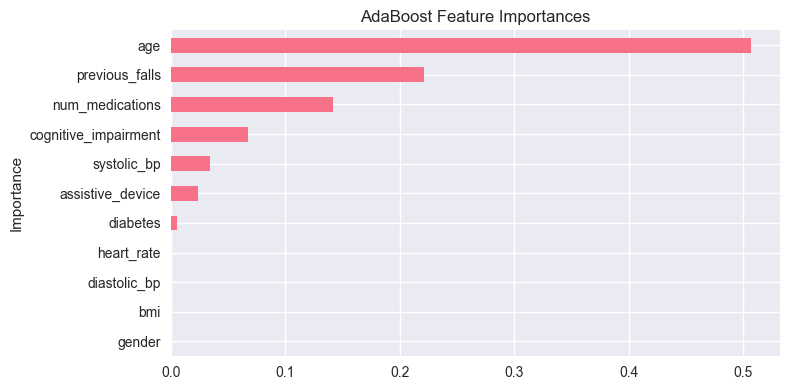

In [47]:
#Feature importance for Adaboost model
# Get the selector and the fitted AdaBoost
selector = pipeline.named_steps['feature_select']
ada      = pipeline.named_steps['ada']

#  Which features survived the Lasso‐step?
mask = selector.get_support()
selected_features = X_train.columns[mask]

# Pull AdaBoost’s feature_importances_
importances = ada.feature_importances_

# Combine into a sorted DataFrame
feat_imp = pd.DataFrame({
    'feature':    selected_features,
    'importance': importances
}).sort_values('importance', ascending=True)


feat_imp.set_index('feature')['importance'].plot.barh(figsize=(8,4))
plt.title("AdaBoost Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### 11. Evaluating Adaboost 

Detailed Classification Report:
              precision    recall  f1-score   support

     No Fall       0.94      0.80      0.86       280
        Fall       0.65      0.88      0.75       120

    accuracy                           0.82       400
   macro avg       0.79      0.84      0.81       400
weighted avg       0.85      0.82      0.83       400


Confusion Matrix:


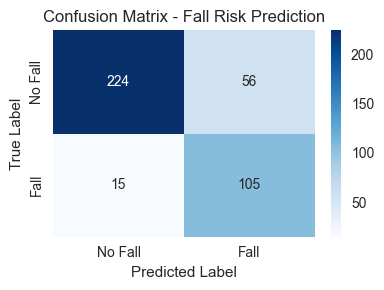

True Negatives: 224
False Positives: 56
False Negatives: 15
True Positives: 105

Additional Metrics:
Sensitivity (Recall): 0.875
Specificity: 0.8


In [48]:
# Create detailed classification report and confusion matrix
y_pred_best = ada_model.predict(X_test)
y_pred_proba = ada_model.predict_proba(X_test)[:, 1]


print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['No Fall', 'Fall']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_best)
labels = ['No Fall', 'Fall']
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Fall Risk Prediction')
plt.tight_layout()
plt.show()
print("True Negatives:", cm[0,0])
print("False Positives:", cm[0,1]) 
print("False Negatives:", cm[1,0])
print("True Positives:", cm[1,1])

# Calculate additional metrics
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])  # True Positive Rate
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # True Negative Rate


print("\nAdditional Metrics:")
print("Sensitivity (Recall): " + str(round(sensitivity, 3)))
print("Specificity: " + str(round(specificity, 3)))



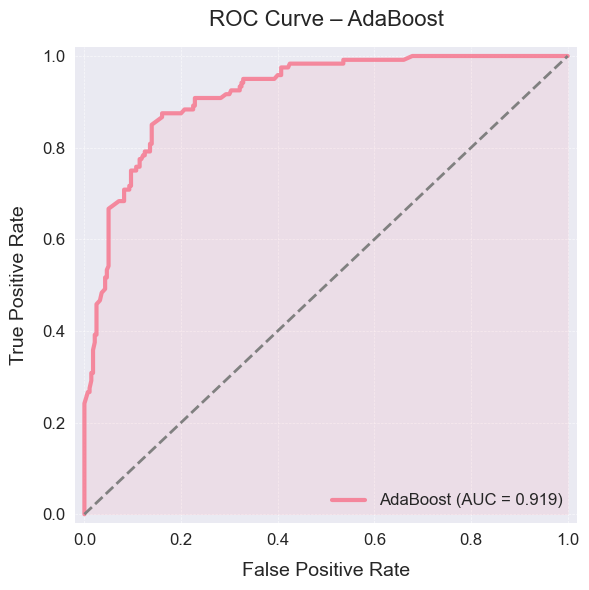

In [49]:
from sklearn.metrics import roc_curve, auc

# Compute FPR, TPR and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Set up the plot
plt.figure(figsize=(6, 6))
plt.plot(
    fpr, tpr,
    color='C0',
    lw=3,
    alpha=0.8,
    label=f'AdaBoost (AUC = {roc_auc:.3f})'
)
# Fill under the ROC curve
plt.fill_between(fpr, tpr, alpha=0.1, color='C0')

# Plot the random-chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)

# Aesthetic tweaks
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel('False Positive Rate', fontsize=14, labelpad=10)
plt.ylabel('True Positive Rate', fontsize=14, labelpad=10)
plt.title('ROC Curve – AdaBoost', fontsize=16, pad=15)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


### 12. Testing on Unseen Data (Min 100 Samples)

In [50]:
df = generate_mock_dataset(random_seed=5, n_samples=100)
df['num_medications'] = df['sedatives'] + df['antihypertensives'] + df['antidepressants']
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
df['assistive_device'] = df['assistive_device'].map({'None': 0, 'Cane': 1, 'Walker': 2, 'Wheelchair': 3})

X = df.drop(['patient_id', 'fall_occurred'], axis=1)
y = df['fall_occurred']

Detailed Classification Report:
              precision    recall  f1-score   support

     No Fall       0.95      0.80      0.87        70
        Fall       0.66      0.90      0.76        30

    accuracy                           0.83       100
   macro avg       0.80      0.85      0.81       100
weighted avg       0.86      0.83      0.84       100


Confusion Matrix:


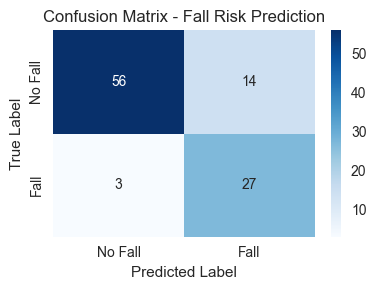

True Negatives: 56
False Positives: 14
False Negatives: 3
True Positives: 27

Additional Metrics:
Sensitivity (Recall): 0.9
Specificity: 0.8


In [51]:
# Create detailed classification report and confusion matrix
y_pred_best = ada_model.predict(X)
y_pred_proba = ada_model.predict_proba(X)[:, 1]


print("Detailed Classification Report:")
print(classification_report(y, y_pred_best, target_names=['No Fall', 'Fall']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y, y_pred_best)
labels = ['No Fall', 'Fall']
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Fall Risk Prediction')
plt.tight_layout()
plt.show()
print("True Negatives:", cm[0,0])
print("False Positives:", cm[0,1]) 
print("False Negatives:", cm[1,0])
print("True Positives:", cm[1,1])

# Calculate additional metrics
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])  # True Positive Rate
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # True Negative Rate


print("\nAdditional Metrics:")
print("Sensitivity (Recall): " + str(round(sensitivity, 3)))
print("Specificity: " + str(round(specificity, 3)))

